# Logistic Regression with Sklearn

This notebook creates and measures a logistic regression model with sklearn.

* Method: [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* Dataset: Titanic

## Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import seaborn as sb
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

## Load and Prepare the Data

In [6]:
DATA_FILE = "../../data/titanic.csv"

In [7]:
# Import the data
columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
data = pd.read_csv(DATA_FILE)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Variable Descriptions**

* PassengerId: unique passenger id
* Survived: Survival (0 = No; 1 = Yes)
* Pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* Name: Name
* Sex: Sex
* Age: Age
* SibSp: Number of Siblings/Spouses Aboard
* Parch: Number of Parents/Children Aboard
* Ticket: Ticket Number
* Fare: Passenger Fare (British pound)
* Cabin: Cabin
* Embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

### Ensure Our Dependent Variable is Binary

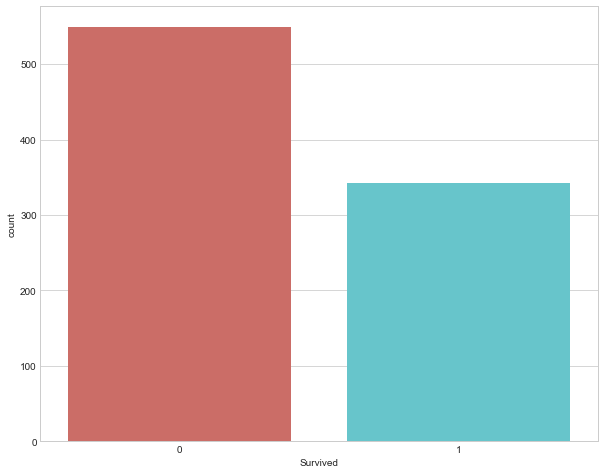

In [8]:
# Ensure we have a binary dependent variable. Use Seaborn for this.
sb.countplot(x='Survived',data=data, palette='hls')

### Handle Missing Values

In [9]:
# Check for missing values
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
# See how many records we have in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [11]:
# Remove variables that seem irrelevant to our analysis or are almost all empty
data = data.drop(['PassengerId','Name','Ticket','Cabin'], 1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


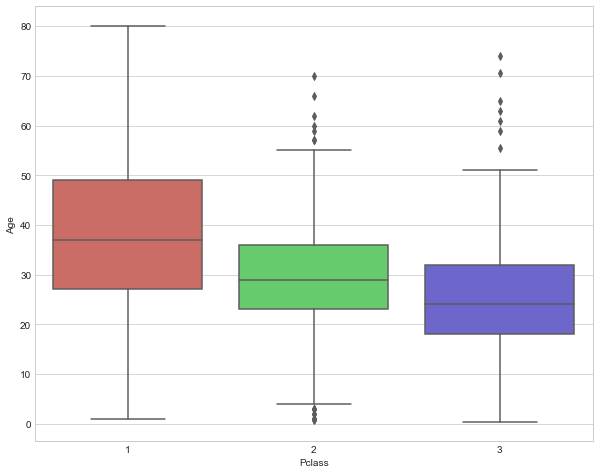

In [12]:
# How is age related to class?
sb.boxplot(x='Pclass', y='Age', data=data, palette='hls')

**Note**: it appears that older passengers are in 1st class and younger passengers 3rd class. There may be some correlation between these two variables.

In [13]:
# Fill in the missing age of the passenger with the mean age of the class he/she is in

# Get the means
pclass_means = data.groupby('Pclass').mean()
pmv = pclass_means['Age'].values
pclass_1_mean = float(pmv[0])
pclass_2_mean = float(pmv[1])
pclass_3_mean = float(pmv[2])

# Create a custom method to assign the age
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return pclass_1_mean
        elif Pclass == 2:
            return pclass_2_mean
        else:
            return pclass_3_mean
    else:
        return float(Age)

In [14]:
# Apply the custom function
data['Age'] = data[['Age', 'Pclass']].apply(age_approx, axis=1)

# See if we have any more null values
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [15]:
# Drop the two records where embarked is null
data.dropna(inplace=True)
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Convert categorical variables to dummy indicators

Models like numbers, not strings.

In [16]:
# Gender
gender = pd.get_dummies(data['Sex'], drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [17]:
# Embarked
embark_location = pd.get_dummies(data['Embarked'], drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [18]:
# Drop the categorical columns and concatenate the previously created dataframes
data.drop(['Sex', 'Embarked'], axis=1, inplace=True)
data = pd.concat([data, gender, embark_location], axis=1)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### Check for independence between features

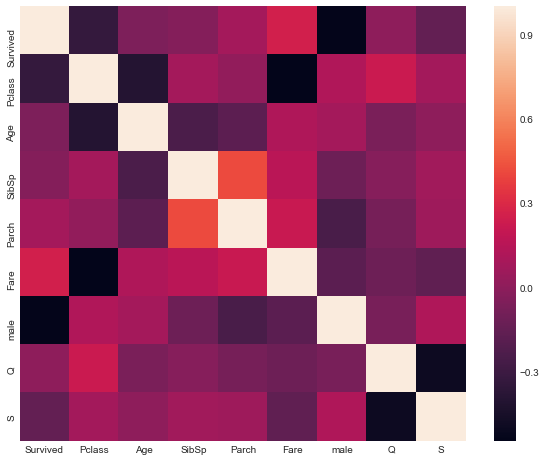

In [19]:
sb.heatmap(data.corr())

In [20]:
# Drop Fare and Pclass as they are not independent of each other
# This is indicated by the black square being present where Pclass and Fare intersect
data.drop(['Fare', 'Pclass'], axis=1, inplace=True)
data.head()

,Survived,Age,SibSp,Parch,male,Q,S
0,0,22.0,1,0,1,0,1
1,1,38.0,1,0,0,0,0
2,1,26.0,0,0,0,0,1
3,1,35.0,1,0,0,0,1
4,0,35.0,0,0,1,0,1


In [21]:
# Prepare the train and test sets

# X = features, y = target
arr = data.values
X = arr[:,1:7]
y = arr[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

## Fit a Logistic Regression Model

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Create Predictions

In [23]:
y_pred = lr.predict(X_test)

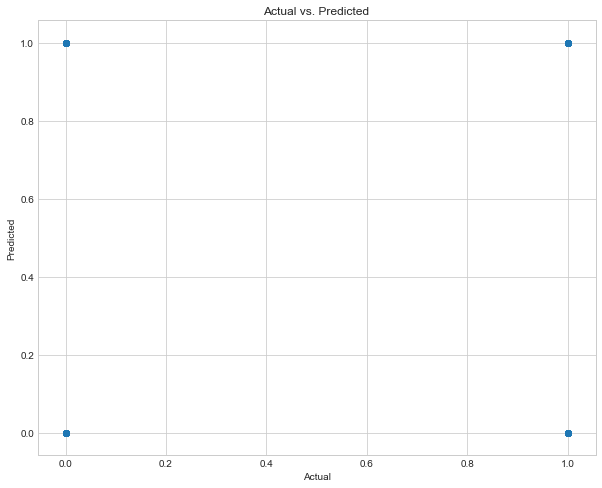

In [24]:
# Create a plot to compare actual labels (Y_test) and the predicted labels (predictions)
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.show()

## Model Evaluation

### Accuracy

The accuracy score is either the fraction (default) or the count (normalize=False) of correct predictions.

In [25]:
print("Accuracy Score: %.2f" % accuracy_score(y_test, y_pred))

Accuracy Score: 0.80


### K-Fold Cross Validation

This estimates the accuracy of the model by splitting the data, fitting a model and computing the score 5 consecutive times. The result is a list of the scores from each consecutive run.

In [26]:
# Get scores for 5 folds over the data
clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

[ 0.78151261  0.79831933  0.77310924  0.78991597  0.78151261]


### Confusion Matrix

**Confusion Matrix for Binary Label**

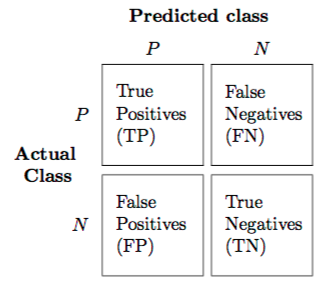

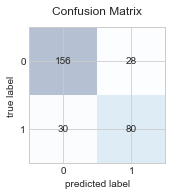

In [27]:
# Plot the multi-label confusion matrix
cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred, 
                      binary=True)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

**Interpretation**: 156 and 80 are the number of correct predictions. 30 and 38 are the number of incorrect predictions.

### Classification Report

In [28]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.84      0.85      0.84       184
        1.0       0.74      0.73      0.73       110

avg / total       0.80      0.80      0.80       294

